# Quantitative segmentation quality estimation

Often we  face the problem, that we have an annnotated image of some data and a segmented version of the same image, which was obtained with some segmentation pipeline (StarDist, EPySeg, PlantSeg, etc). This notebook provides a method to compare the overlap of both ground truth image and achieved segmentation.

In [26]:
import os
import biapol_utilities as biau
from skimage import io, measure, segmentation
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd

%matplotlib notebook

##  Input data
First, let's generate some example data!

In [2]:
blobs = biau.data.blobs()

Let's segment  this and take it as a ground truth image:

<IPython.core.display.Javascript object>


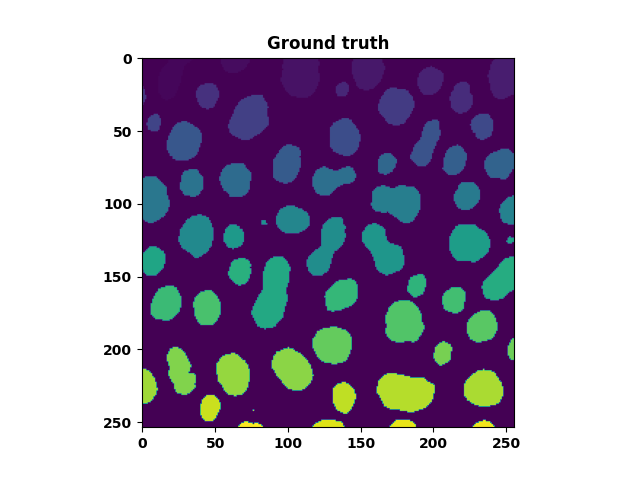

Text(0.5, 1.0, 'Ground truth')

In [3]:
threshold = 128
imageA = (blobs > threshold).astype(np.uint8)
ground_truth = measure.label(imageA)

plt.imshow(ground_truth)
plt.title('Ground truth')

Next, we shuffle the labels and expand them a bit:

In [4]:
# First, shuffle randomly
label_shuffle = np.arange(1, ground_truth.max()+1, 1)
np.random.shuffle(label_shuffle)
label_shuffle = np.append(np.asarray([0]), label_shuffle)  # append 0 at start of array - we don't want to shuffle background
segmented = label_shuffle[ground_truth]

In [5]:
# Second, expand the labels a bit
segmented = segmentation.expand_labels(segmented, 5)

<IPython.core.display.Javascript object>


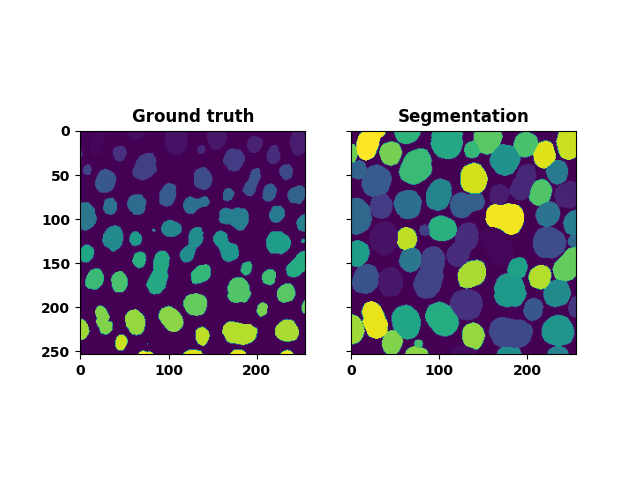

Text(0.5, 1.0, 'Segmentation')

In [6]:
# Plot side by side
fig, axes = plt.subplots(ncols=2, sharex=True, sharey=True)

axes[0].imshow(ground_truth)
axes[0].set_title('Ground truth')

axes[1].imshow(segmented)
axes[1].set_title('Segmentation')

## Re-match labels

Next, use the label-matching from `biapol_utilities` to assign correct labels to both images

In [7]:
segmented = biau.label.match_labels(ground_truth, segmented)

<IPython.core.display.Javascript object>


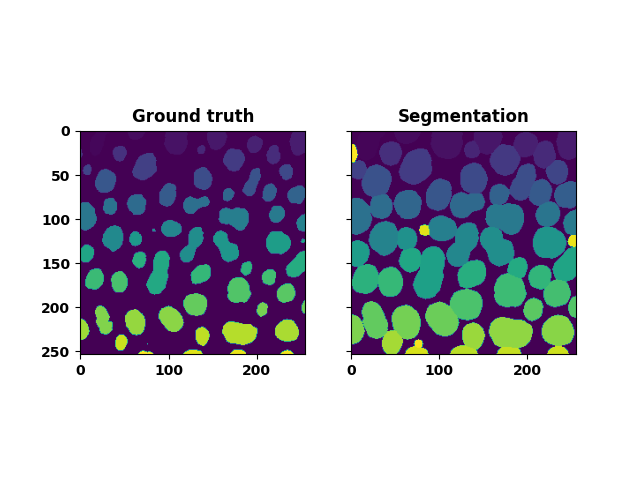

Text(0.5, 1.0, 'Segmentation')

In [8]:
# Plot side by side
fig, axes = plt.subplots(ncols=2, sharex=True, sharey=True)

axes[0].imshow(ground_truth)
axes[0].set_title('Ground truth')

axes[1].imshow(segmented)
axes[1].set_title('Segmentation')

## Compare labels:  Labelwise Jaccard-index

Lastly, we calculate the *label-wise Jaccard index* to measure the intersection over union (IoU) between corresponding pairs of labels.

In [9]:
result = biau.label.compare_labels(ground_truth, segmented)
result

,label,jaccard_score,dice_score
0,0,0.496847,0.663858
1,1,0.518102,0.682566
2,2,0.470130,0.639576
3,3,0.623552,0.768133
4,4,0.602546,0.751986
...,...,...,...
63,63,0.262857,0.416290
64,64,0.000000,0.000000
65,65,0.000000,0.000000
66,66,0.000000,0.000000


Let's also visualize this: To do this, we create a new image and assign the jaccard-index result value to every pixel depending on the label.

In [44]:
LUT_jaccard = result['jaccard_score'].to_numpy()
LUT_dice = result['dice_score'].to_numpy()

# set segmentation quality of background to zero
LUT_jaccard[0] = np.nan
LUT_dice[0] = np.nan

# create score map
JI_map = LUT_jaccard[segmented]
DI_map = LUT_dice[segmented]

<IPython.core.display.Javascript object>


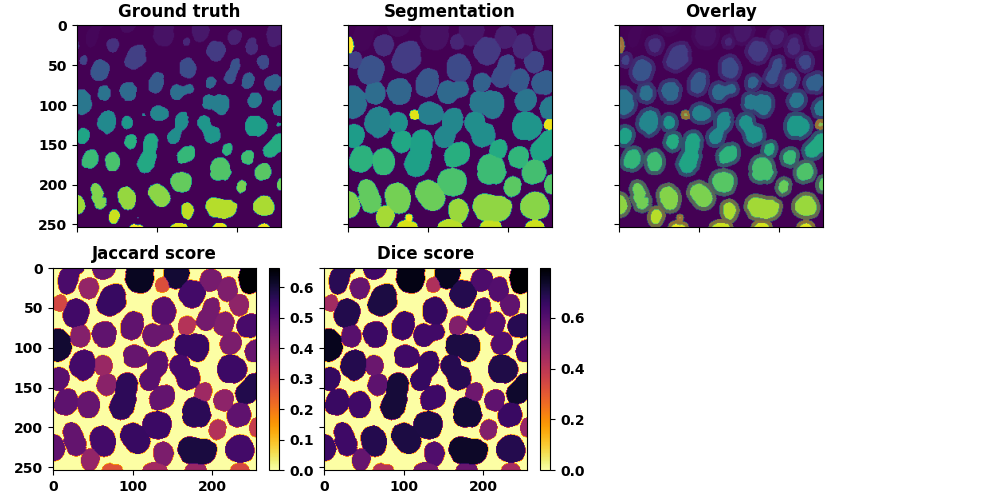

(-0.5, 255.5, 253.5, -0.5)

In [48]:
# Plot side by side
fig, axes = plt.subplots(nrows=2, ncols=3, sharex=True, sharey=True, figsize=(10,5))
fig.subplots_adjust(left=0.05, bottom=0.06, right=0.85, top=0.95, wspace=0.05)


# Plot ground truth
axes[0, 0].imshow(ground_truth)
axes[0, 0].set_title('Ground truth')

# Plot segmentation
axes[0, 1].imshow(segmented)
axes[0, 1].set_title('Segmentation')

# Plot overlay
axes[0, 2].imshow(ground_truth)
axes[0, 2].imshow(segmented, alpha=0.5)
axes[0, 2].set_title('Overlay')

# Plot Jaccard index map
im = axes[1, 0].imshow(JI_map, cmap='inferno_r')
axes[1, 0].set_title('Jaccard score')
cbar = fig.colorbar(im, ax=axes[1, 0])

# Plot Dice score map
im2 = axes[1, 1].imshow(DI_map, cmap='inferno_r')
axes[1, 1].set_title('Dice score')
cbar2 = fig.colorbar(im2, ax=axes[1, 1])

axes[-1, -1].axis('off')

## Compare-labels: Feature-wise
It may be an interesting approach to not only check the pixel-wise agreement between segmentation and annnootation but to also check whether certain features are preserved in the segmentation. For this, the (shape-) features are calculated in both ground_truth annotation and segmented image with scikit-image regionprops.

In [40]:
properties = ['label', 'area', 'eccentricity', 'orientation']
features_gt = measure.regionprops_table(ground_truth, properties=properties)
features_seg = measure.regionprops_table(segmented, properties=properties)

features_gt = pd.DataFrame(features_gt)
features_seg = pd.DataFrame(features_seg)
features_gt

,label,area,eccentricity,orientation
0,1,415,0.878888,-0.433915
1,2,181,0.822705,-1.513862
2,3,646,0.386542,-0.079653
3,4,426,0.324798,-0.400592
4,5,465,0.780472,-0.044317
...,...,...,...,...
58,59,1,0.000000,0.785398
59,60,87,0.969263,-1.560717
60,61,73,0.951468,-1.567605
61,62,49,0.942191,-1.554054


Visualize as histograms

<IPython.core.display.Javascript object>


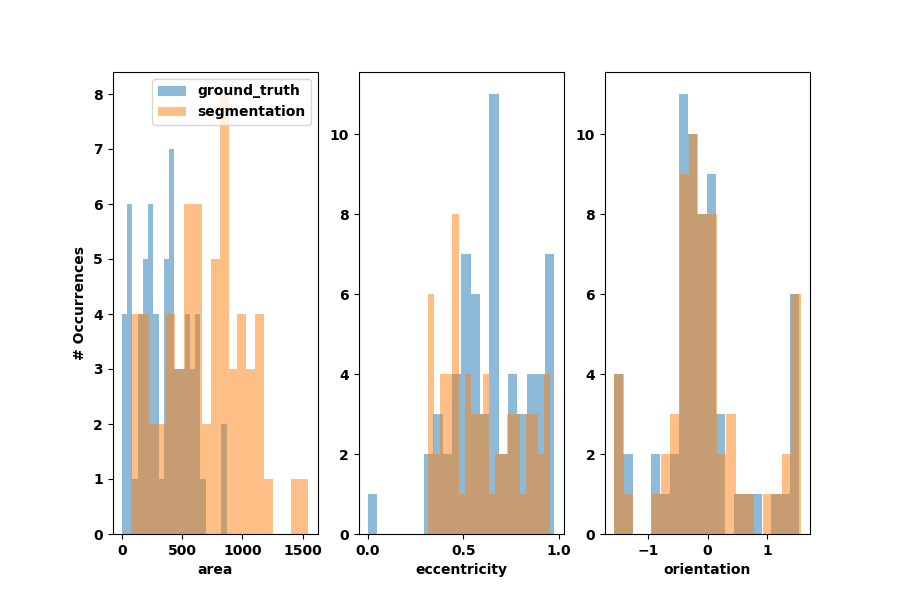

Text(0, 0.5, '# Occurrences')

In [43]:
fig, axes = plt.subplots(nrows=1, ncols=len(properties)-1, figsize=(9,6))

ax_idx = 0
for idx, prop in enumerate(properties):
    if  prop == 'label':
        continue
    
    axes[ax_idx].hist(features_gt[prop], label='ground_truth', bins=20, alpha=0.5)
    axes[ax_idx].hist(features_seg[prop], label='segmentation', bins=20, alpha=0.5)
    axes[ax_idx].set_xlabel(prop)
    ax_idx += 1
    
axes[0].legend()
axes[0].set_ylabel('# Occurrences')